In [27]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import LineString, Point, Polygon, MultiLineString
import osmnx as ox

In [28]:
# define and run overpass query

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Jaipur Municipal Corporation"]["boundary"="administrative"]->.searchArea;
(
  relation["type"="route"]["route"="bus"](area.searchArea);
);
out body;
>;
out skel qt;
"""

response = requests.post(overpass_url, data={'data': overpass_query}) # Send the POST request
response.raise_for_status() # Raise error if request failed
data = response.json() # Parse response as JSON

In [29]:
# # -----------------
# # Print the number of bus route relations found
# relations = [el for el in data['elements'] if el['type'] == 'relation']
# print(f"Found {len(relations)} bus route relations.")

# # Print details about the first route
# if relations:
#     first = relations[0]
#     print("Example bus route:")
#     print("ID:", first.get('id'))
#     print("Tags:", first.get('tags', {}))

In [30]:
# -----------------
# create GeoDatFrame for mapping
nodes = {el['id']: el for el in data['elements'] if el['type'] == 'node'}
ways = {el['id']: el for el in data['elements'] if el['type'] == 'way'}

# For each relation, collect its geometry and ref/name
route_geoms = []
route_labels = []
route_operator = []
route_interval = []

for rel in relations:
    # Get route number (ref) or fall back to 'name'
    ref = rel.get('tags', {}).get('ref') or rel.get('tags', {}).get('name') or f"relation {rel['id']}"
    operator = rel.get('tags', {}).get('operator')
    interval = rel.get('tags', {}).get('interval')
    # Find member ways
    member_way_ids = [m['ref'] for m in rel['members'] if m['type'] == 'way']
    coords = []
    for wid in member_way_ids:
        way = ways.get(wid)
        if not way:
            continue
        line_coords = []
        for nid in way['nodes']:
            node = nodes.get(nid)
            if node:
                line_coords.append((node['lon'], node['lat']))
        if len(line_coords) > 1:
            coords.append(LineString(line_coords))
    if coords:
        # Combine into MultiLine if more than one segment, else just use the LineString
        geom = coords[0] if len(coords) == 1 else gpd.GeoSeries(coords).unary_union
        route_geoms.append(geom)
        route_labels.append(ref)
        route_operator.append(operator)
        route_interval.append(interval)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame({'route': route_labels, 'operator': route_operator, 'interval': route_interval, 'geometry': route_geoms}, crs="EPSG:4326")
gdf.sort_values('route', inplace=True)
gdf = gdf.query('route != "Jaipur To Bharatpur (RSRTC Express)"') # remove long distance routes 
gdf.head()

,route,operator,interval,geometry
20,1,JCTSL,None,"MULTILINESTRING ((75.84887 26.91825, 75.84861 ..."
19,1,JCTSL,None,"MULTILINESTRING ((75.78808 27.04376, 75.78825 ..."
11,1 Mini/1,JCTSL,00:30,"MULTILINESTRING ((75.77035 26.99856, 75.77025 ..."
12,1 Mini/1,JCTSL,00:30,"MULTILINESTRING ((75.76888 27.02900, 75.76893 ..."
29,11,JCTSL,None,"MULTILINESTRING ((75.89883 26.77621, 75.89991 ..."


In [ ]:
# add a column for hex6 color based on route
unique_routes = gdf['route'].unique()
cmap = plt.get_cmap('tab20', len(unique_routes))
color_array = {route: mcolors.to_hex(cmap(i)) for i, route in enumerate(unique_routes)}
gdf['color'] = gdf['route'].map(color_array)
gdf.head()

# save to geojson
gdf.to_file("../../public/geojson/bus_routes.geojson", driver='GeoJSON')

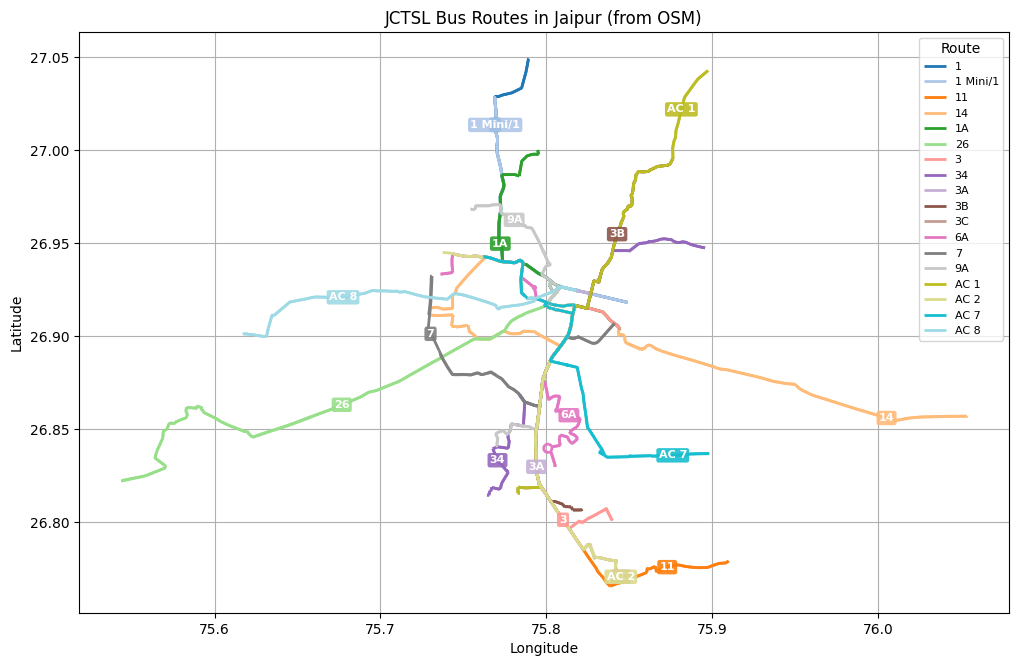

In [ ]:
# # -----------------
# # Plot and label 1

# # 1. Get unique routes and assign each a color
# unique_routes = gdf['route'].unique()
# cmap = plt.get_cmap('tab20', len(unique_routes))
# route_to_color = {route: cmap(i) for i, route in enumerate(unique_routes)}

# # 2. Plot, assigning color by 'route'
# fig, ax = plt.subplots(figsize=(12, 8))

# for route, group in gdf.groupby('route'):
#     group.plot(ax=ax, color=route_to_color[route], linewidth=2, label=route)

#     # For labeling: use the centroid or a representative point
#     # If MultiLineString, use the largest geometry; otherwise, use the geometry itself
#     # For lines, the centroid may not be on the line, so interpolate a point along the line

#     geom = group.geometry.unary_union
#     label_point = None
#     if geom.geom_type == 'MultiLineString':
#         line = max(geom.geoms, key=lambda l: l.length)
#         label_point = line.interpolate(0.5, normalized=True)
#     elif geom.geom_type == 'LineString':
#         label_point = geom.interpolate(0.5, normalized=True)
#     elif geom.geom_type == 'Point':
#         label_point = geom
#     else:
#         label_point = geom.centroid # fallback to centroid


#     # Add the label
#     ax.text(
#         label_point.x, label_point.y, str(route),
#         fontsize=8, color='white', weight='bold',
#         ha='center', va='center',
#         bbox=dict(facecolor=route_to_color[route], edgecolor='none', boxstyle='round,pad=0.2', alpha=0.9)
#     )


# plt.title('JCTSL Bus Routes in Jaipur (from OSM)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title="Route", loc='upper right', fontsize=8)
# plt.grid(True)
# plt.show()

In [25]:
# get bus stops using OSMNX
place_name = "Jaipur Municipal Corporation"
tags={'highway': 'bus_stop'} 

area = ox.geocode_to_gdf(place_name)
bus_stops = ox.features.features_from_place(place_name, tags)
bus_stops = gpd.GeoDataFrame(bus_stops, crs="EPSG:4326")
bus_stops = bus_stops[['name','bus_routes','geometry']] 
bus_stops.reset_index(drop=True, inplace=True)
bus_stops.head()

,name,bus_routes,geometry
0,Ghat ki guni,27,POINT (75.86123 26.89480)
1,Ramgarh Mod,NaN,POINT (75.83951 26.94410)
2,Harmada,NaN,POINT (75.76933 27.01505)
3,Kalyan Nagar,NaN,POINT (75.79430 26.82628)
4,Maharani College,NaN,POINT (75.81614 26.91234)


In [26]:
# save to geojson
bus_stops.to_file("../../public/geojson/bus_stops.geojson", driver='GeoJSON')